In [ ]:
import math
from datetime import datetime, timedelta

%pip install cdsapi
%pip install netcdf4
%pip install cartopy
%pip install cfgrib eccodes

import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cdsapi
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import glob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 104.1 MB/s eta 0:00:00


In [ ]:
# Inicializa a API do CDS com verificação SSL desativada
client = cdsapi.Client(url='https://ads.atmosphere.copernicus.eu/api', key='56ff124d-08b8-4fe3-a524-e45272516d72', verify=False)

dataset = "cams-gridded-solar-radiation"
request = {
    "variable": ["global_horizontal_irradiation"],
    "sky_type": ["clear"],
    "version": ["4.6"],
    "year": ["2022"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "area": [51.0, -5, 42.0, 8.0]

}
client.retrieve(dataset, request).download()


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2026-01-22 08:24:15,743 INFO

4ed76d6f774ef67e541285f548cf3724.zip:   0%|          | 0.00/56.0M [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'object-store.os-api.cci2.ecmwf.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


'4ed76d6f774ef67e541285f548cf3724.zip'

In [ ]:

# -------------------------------------------------
# 1️Combine every year
# -------------------------------------------------
files = sorted(glob.glob("v4.6_GHI_clear_2022_*.nc"))

ds = xr.open_mfdataset(
    files,
    combine="by_coords",
    engine="h5netcdf",
    chunks={"time": 1000}   # 👈 adjust chunk size
)

In [ ]:
ghi_sum = (
    ds["global_horizontal_clear_sky_irradiation"]
    .sum(dim="time")
)

ghi_energy = ghi_sum * 0.25

In [ ]:
ghi_energy = (
    ds["global_horizontal_clear_sky_irradiation"]
    .sum(dim="time")
    .compute()   # only this result is loaded
)

In [ ]:
ds = ds.astype("float32")

In [ ]:
ds["global_horizontal_clear_sky_irradiation"].sum(dim="time")

<xarray.DataArray 'global_horizontal_clear_sky_irradiation' (latitude: 90,
                                                             longitude: 130)> Size: 47kB
dask.array<sum-aggregate, shape=(90, 130), dtype=float32, chunksize=(90, 130), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 360B 50.95 50.85 50.75 ... 42.25 42.15 42.05
  * longitude  (longitude) float32 520B -4.95 -4.85 -4.75 ... 7.75 7.85 7.95
Attributes:
    long_name:    global shortwave downward irradiation assuming clear-sky co...
    valid_range:  [  0 253]
    units:        W h m-2
    info:         Valid values 0-253 should be multiplied by 1.2. Value 255 d...

In [ ]:
df_sum = ghi_energy.to_dataframe(name="GHI_energy_Wh_m2").reset_index()

ghi_grid = df_sum.pivot(
    index="latitude",
    columns="longitude",
    values="GHI_energy_Wh_m2"
)
df_sum

,latitude,longitude,GHI_energy_Wh_m2
0,50.950001,-4.95,1719760.8
1,50.950001,-4.85,1720327.2
2,50.950001,-4.75,1720896.0
3,50.950001,-4.65,1721414.4
4,50.950001,-4.55,1721959.2
...,...,...,...
11695,42.049999,7.55,0.0
11696,42.049999,7.65,0.0
11697,42.049999,7.75,0.0
11698,42.049999,7.85,0.0


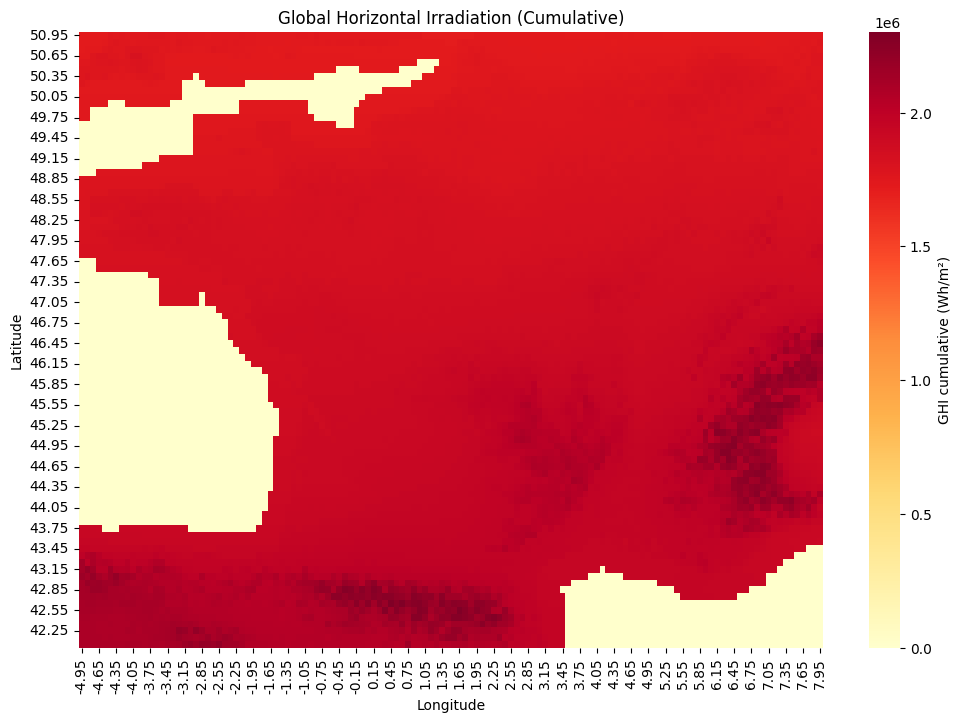

In [ ]:
# CODE POUR IRRADIATION HEAT MAP
plt.figure(figsize=(12,8))
sns.heatmap(
    ghi_grid[::-1],  # inverse les lignes pour que le Sud soit en bas
    cmap="YlOrRd",
    cbar_kws={'label': 'GHI cumulative (Wh/m²)'}
)
plt.title("Global Horizontal Irradiation (Cumulative)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


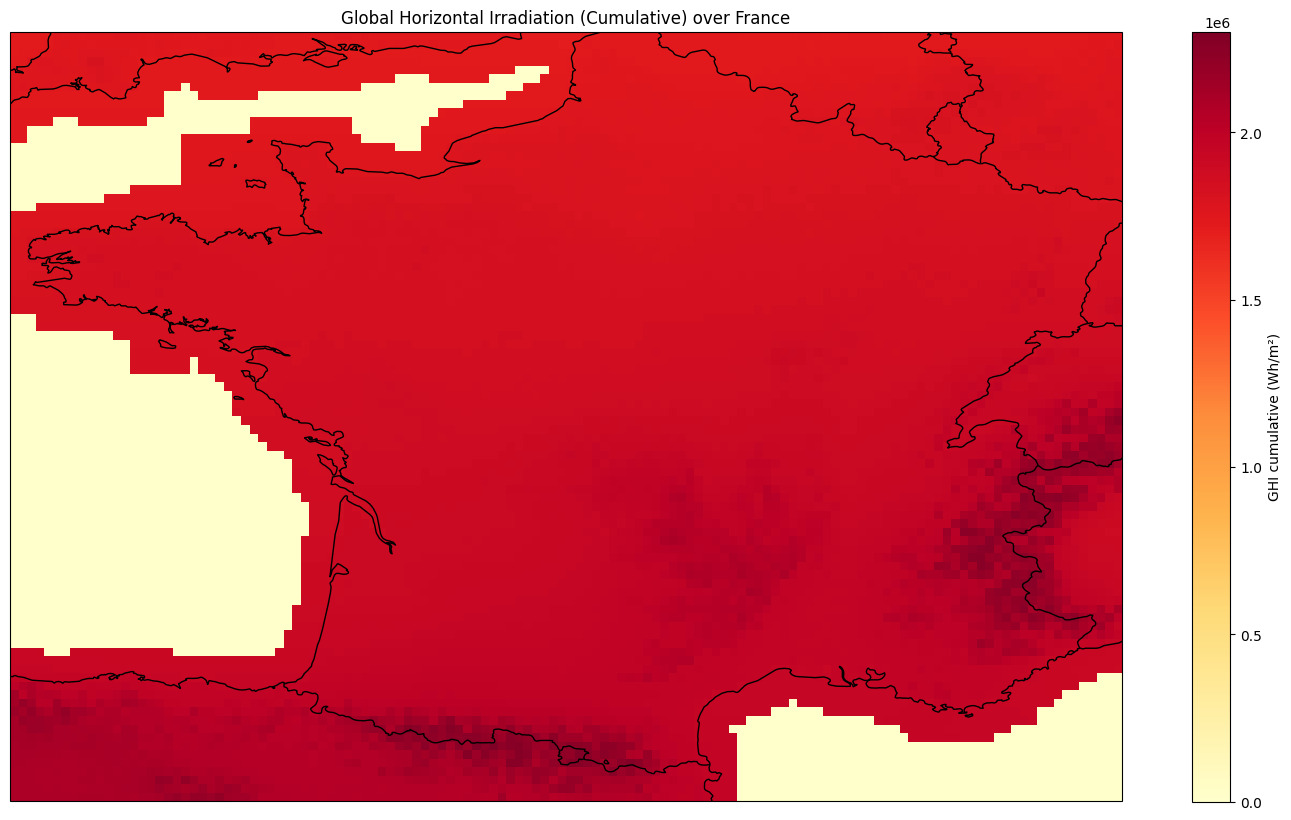

In [ ]:
# CODE POUR IRRADIATION HEATMAP + CARTE DES PAYS
# Zone CAMS
lat_min, lat_max = 42.0, 51.0
lon_min, lon_max = -5.0, 8.0

plt.figure(figsize=(18,10))

# Axe géographique Cartopy
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Ajouter carte
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)

# -----------------------
# Heatmap CAMS
# -----------------------
# Créer les coordonnées exactes de la grille
lon = np.array(sorted(ghi_grid.columns))
lat = np.array(sorted(ghi_grid.index))  # latitudes croissantes

# Meshgrid pour imshow
Lon, Lat = np.meshgrid(lon, lat)

# Afficher la heatmap
pcm = ax.pcolormesh(
    Lon, Lat, ghi_grid.values,  # pas besoin d'inverser
    cmap='YlOrRd',
    alpha=1,
    shading='auto'              # très important pour que les pixels correspondent
)

# Ajouter colorbar
plt.colorbar(pcm, ax=ax, label='GHI cumulative (Wh/m²)')

# Axes et titre
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Global Horizontal Irradiation (Cumulative) over France")
plt.show()

In [ ]:
#CODE POUR TEMPERATURE

In [ ]:
# Inicializa a API do CDS com verificação SSL desativada
c = cdsapi.Client(url='https://ads.atmosphere.copernicus.eu/api', key='56ff124d-08b8-4fe3-a524-e45272516d72', verify=False)



dataset = "cams-global-reanalysis-eac4-monthly"
request = {
    "variable": ["2m_temperature"],
    "year": ["2022"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "product_type": ["monthly_mean"],
    "data_format": "grib",
    "area": [51.0, -5, 42.0, 8.0]
}

c.retrieve(dataset, request).download()

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ads.atmosphere.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
2026-01-22 08:30:22,205 INFO

fc76e33400e82ede347d0eac8828ded4.grib:   0%|          | 0.00/6.75k [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'object-store.os-api.cci2.ecmwf.int'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


'fc76e33400e82ede347d0eac8828ded4.grib'

In [ ]:
ds = xr.open_dataset(
    "fc76e33400e82ede347d0eac8828ded4.grib",
    engine="cfgrib"
)

ds

<xarray.Dataset> Size: 12kB
Dimensions:     (time: 12, latitude: 13, longitude: 18)
Coordinates:
  * time        (time) datetime64[ns] 96B 2022-01-01 2022-02-01 ... 2022-12-01
  * latitude    (latitude) float64 104B 51.0 50.25 49.5 ... 43.5 42.75 42.0
  * longitude   (longitude) float64 144B -5.0 -4.25 -3.5 -2.75 ... 6.25 7.0 7.75
    number      int64 8B ...
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
    valid_time  (time) datetime64[ns] 96B ...
Data variables:
    t2m         (time, latitude, longitude) float32 11kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-22T08:30 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
# Annual mean over time (removes the time dimension)
t2m_annual_mean = ds["t2m"].mean(dim="time")

# Convert from Kelvin to Celsius
t2m_annual_mean_c = t2m_annual_mean - 273.15

# Convert to DataFrame
df_t2m_annual = (
    t2m_annual_mean_c
    .to_dataframe(name="T2m_mean_annual_C")
    .reset_index()
)

df_t2m_annual


,latitude,longitude,number,step,surface,T2m_mean_annual_C
0,51.0,-5.00,0,0 days,0.0,12.681061
1,51.0,-4.25,0,0 days,0.0,11.859222
2,51.0,-3.50,0,0 days,0.0,11.398712
3,51.0,-2.75,0,0 days,0.0,11.587769
4,51.0,-2.00,0,0 days,0.0,11.740631
...,...,...,...,...,...,...
229,42.0,4.75,0,0 days,0.0,18.419189
230,42.0,5.50,0,0 days,0.0,18.585754
231,42.0,6.25,0,0 days,0.0,18.768982
232,42.0,7.00,0,0 days,0.0,19.305054


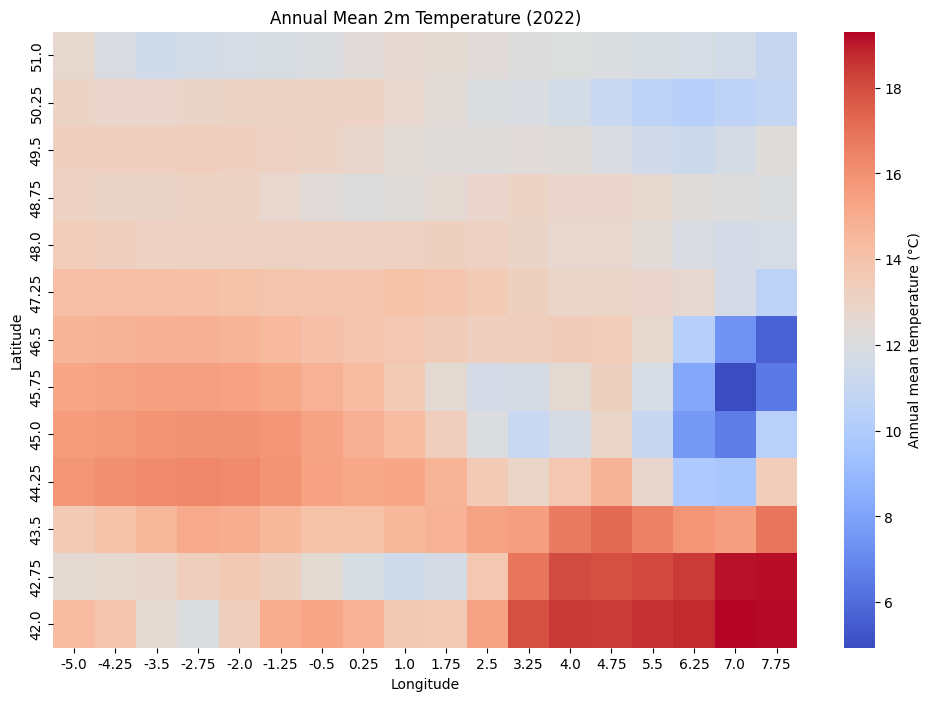

In [ ]:
# Create pivot grid: latitudes as index, longitudes as columns
t2m_grid = df_t2m_annual.pivot(
    index="latitude",
    columns="longitude",
    values="T2m_mean_annual_C"
)

# Sort axes (South → North, West → East)
t2m_grid = t2m_grid[sorted(t2m_grid.columns)]      # longitudes increasing
t2m_grid = t2m_grid.sort_index(ascending=True)    # latitudes increasing
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(
    t2m_grid[::-1],          # invert rows so South is at the bottom
    cmap="coolwarm",         # blue (cold) → red (hot)
    cbar_kws={'label': 'Annual mean temperature (°C)'}
)

plt.title("Annual Mean 2m Temperature (2022)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


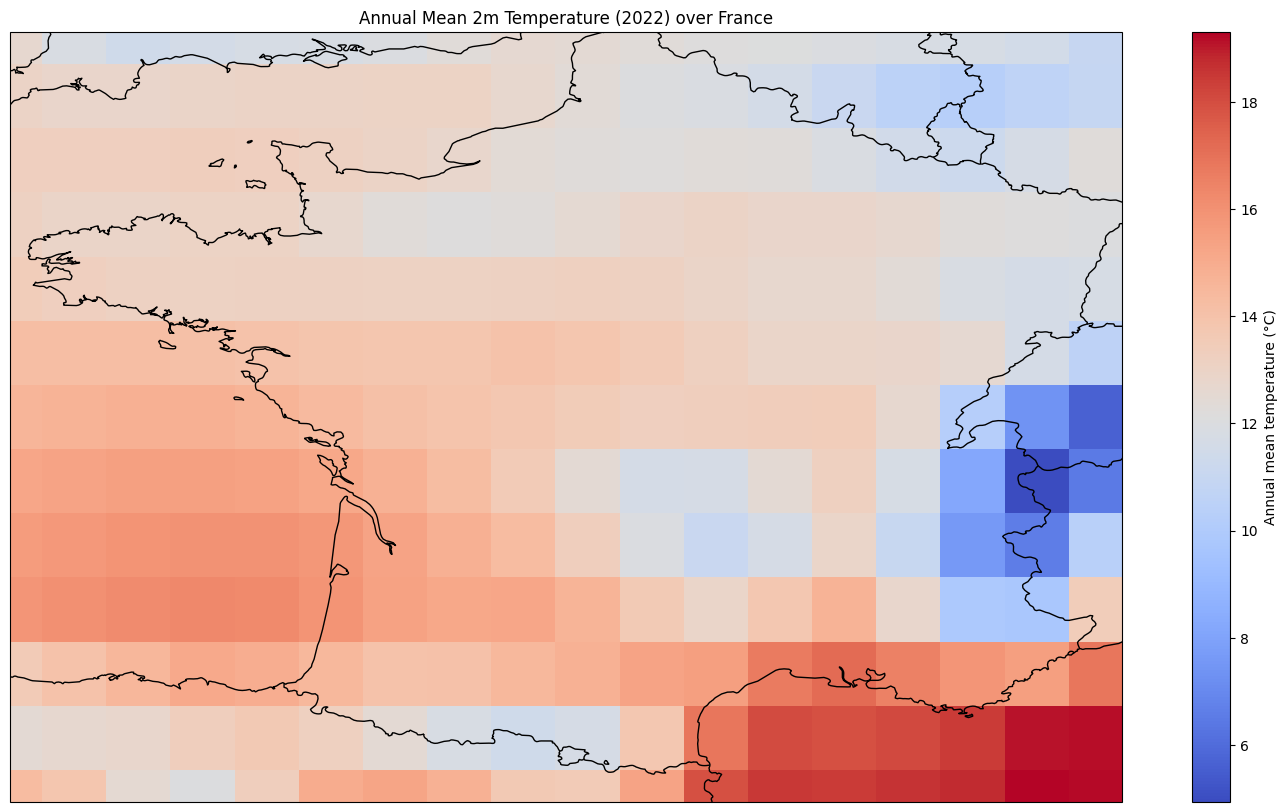

In [ ]:
# CAMS area
lat_min, lat_max = 42.0, 51.0
lon_min, lon_max = -5.0, 8.0

plt.figure(figsize=(18, 10))

# Geographic axis (Cartopy)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)

# -----------------------
# Temperature heatmap
# -----------------------
# Create exact grid coordinates
lon = np.array(sorted(t2m_grid.columns))
lat = np.array(sorted(t2m_grid.index))  # latitudes increasing

# Meshgrid for pcolormesh
Lon, Lat = np.meshgrid(lon, lat)

# Plot temperature heatmap
pcm = ax.pcolormesh(
    Lon, Lat, t2m_grid.values,
    cmap="coolwarm",        # blue (cold) → red (hot)
    alpha=1,
    shading="auto"
)

# Colorbar
plt.colorbar(pcm, ax=ax, label="Annual mean temperature (°C)")

# Labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Annual Mean 2m Temperature (2022) over France")

plt.show()

In [ ]:
# Convert annual mean temperature from °C to K
df_t2m_annual["T2m_mean_annual_K"] = (
    df_t2m_annual["T2m_mean_annual_C"] + 273.15
)

# Apply the formula: -0.35 * (T - (273 + 25))
df_t2m_annual["temp_factor"] = (
    -0.35 * (df_t2m_annual["T2m_mean_annual_K"] - (273 + 25))
)

df_t2m_annual

,latitude,longitude,number,step,surface,T2m_mean_annual_C,T2m_mean_annual_K,temp_factor
0,51.0,-5.00,0,0 days,0.0,12.681061,285.831055,4.259131
1,51.0,-4.25,0,0 days,0.0,11.859222,285.009216,4.546774
2,51.0,-3.50,0,0 days,0.0,11.398712,284.548706,4.707953
3,51.0,-2.75,0,0 days,0.0,11.587769,284.737762,4.641783
4,51.0,-2.00,0,0 days,0.0,11.740631,284.890625,4.588281
...,...,...,...,...,...,...,...,...
229,42.0,4.75,0,0 days,0.0,18.419189,291.569183,2.250786
230,42.0,5.50,0,0 days,0.0,18.585754,291.735748,2.192488
231,42.0,6.25,0,0 days,0.0,18.768982,291.918976,2.128358
232,42.0,7.00,0,0 days,0.0,19.305054,292.455048,1.940733


In [ ]:
# Interpoler la température sur la grille GHI
t2m_on_ghi_grid = t2m_annual_mean_c.interp(
    latitude=ghi_energy.latitude,
    longitude=ghi_energy.longitude,
    method="nearest"
)

t2m_on_ghi_grid




<xarray.DataArray 't2m' (latitude: 90, longitude: 130)> Size: 47kB
array([[12.681061, 12.681061, 12.681061, ..., 10.962341,       nan,
              nan],
       [12.681061, 12.681061, 12.681061, ..., 10.962341,       nan,
              nan],
       [12.681061, 12.681061, 12.681061, ..., 10.962341,       nan,
              nan],
       ...,
       [14.356873, 14.356873, 14.356873, ..., 19.194489,       nan,
              nan],
       [14.356873, 14.356873, 14.356873, ..., 19.194489,       nan,
              nan],
       [14.356873, 14.356873, 14.356873, ..., 19.194489,       nan,
              nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 360B 50.95 50.85 50.75 ... 42.25 42.15 42.05
  * longitude  (longitude) float32 520B -4.95 -4.85 -4.75 ... 7.75 7.85 7.95
    number     int64 8B ...
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
Attributes: (12/31)
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      234
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgua
    ...                                       ...
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            unknown

In [ ]:
temp_factor_on_ghi = -0.35 * (
    (t2m_on_ghi_grid + 273.15) - (273 + 25)
)

GHI_temp_corrected = ghi_energy * temp_factor_on_ghi

df_final = (
    GHI_temp_corrected
    .to_dataframe(name="GHI_temp_corrected")
    .reset_index()
)

df_final


,latitude,longitude,number,step,surface,GHI_temp_corrected
0,50.950001,-4.95,0,0 days,0.0,7.324686e+06
1,50.950001,-4.85,0,0 days,0.0,7.327099e+06
2,50.950001,-4.75,0,0 days,0.0,7.329521e+06
3,50.950001,-4.65,0,0 days,0.0,7.331729e+06
4,50.950001,-4.55,0,0 days,0.0,7.829360e+06
...,...,...,...,...,...,...
11695,42.049999,7.55,0,0 days,0.0,0.000000e+00
11696,42.049999,7.65,0,0 days,0.0,0.000000e+00
11697,42.049999,7.75,0,0 days,0.0,0.000000e+00
11698,42.049999,7.85,0,0 days,0.0,NaN


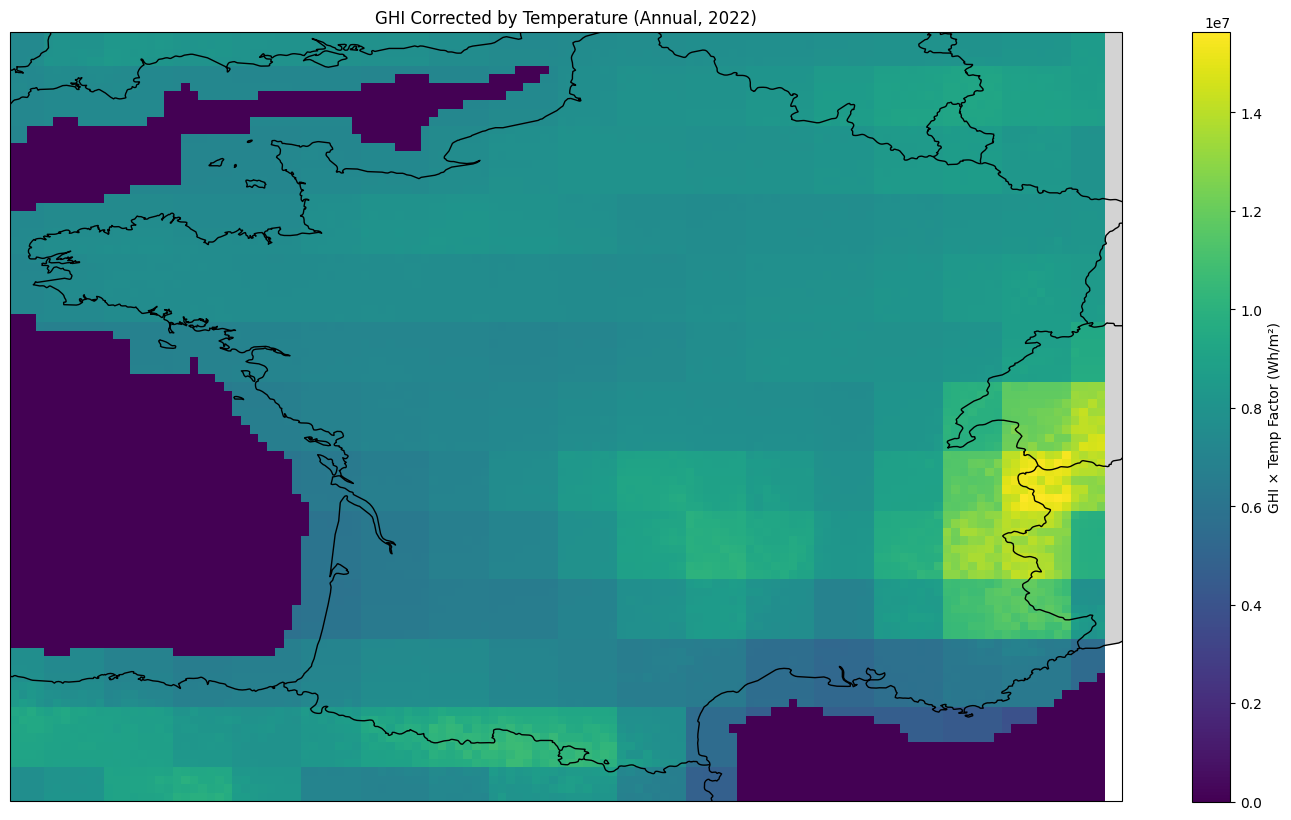

In [ ]:
# CAMS area
lat_min, lat_max = 42.0, 51.0
lon_min, lon_max = -5.0, 8.0

plt.figure(figsize=(18, 10))

# Geographic axis (Cartopy)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.BORDERS, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)

# -----------------------
# Heatmap GHI corrected
# -----------------------
# Create exact grid coordinates
lon = np.array(sorted(df_final['longitude'].unique()))
lat = np.array(sorted(df_final['latitude'].unique()))  # latitudes increasing

# Pivot dataframe to grid
ghi_temp_grid = df_final.pivot(index='latitude', columns='longitude', values='GHI_temp_corrected')
ghi_temp_grid = ghi_temp_grid[sorted(ghi_temp_grid.columns)]
ghi_temp_grid = ghi_temp_grid.sort_index(ascending=True)

# Meshgrid for pcolormesh
Lon, Lat = np.meshgrid(lon, lat)

# Plot heatmap with a nicer color
pcm = ax.pcolormesh(
    Lon, Lat, ghi_temp_grid.values,
    cmap="viridis",          # bleu → vert → jaune
    alpha=1,
    shading="auto"
)
plt.colorbar(pcm, ax=ax, label="GHI × Temp Factor (Wh/m²)")


# Labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GHI Corrected by Temperature (Annual, 2022)")

plt.show()